In [1]:
# To do list:
# - Find Days in drive repository folder
# - Load files of a day:
#   * Infrared Images
#   * Pyranometer Measures
#   * Weather Data

import os, pickle, datetime

import numpy as np
import matplotlib.pylab as plt

from cv2 import imread, IMREAD_UNCHANGED
from scipy import interpolate
from datetime import datetime
from scipy.optimize import fmin_l_bfgs_b

# Load Clear Sky Images, Irradiance, and Weather Station Data

In [7]:
# Load csv file
def _load_csv_file(path):
    return np.loadtxt(open(path, "rb"), delimiter = ",")
# Load infrared frame
def _load_infrared(file): 
    return imread(file, IMREAD_UNCHANGED)

# Path to the original files recorded by device
path_ws = r'C:\Users\Guille\Desktop\troposphere_radiometry_model\data\weather_station'
path_py = r'C:\Users\Guille\Desktop\troposphere_radiometry_model\data\pyranometer'
path_ir = r'C:\Users\Guille\Desktop\troposphere_radiometry_model\data\ir_camera'
# List Inititialization
N_ = []
W_ = []
P_ = []
I_ = []
U_ = []
# loop over directory of infrared day folders
for file in os.listdir(path_ir):
    file_ws = '{}\{}.csv'.format(path_ws, file)
    file_py = '{}\{}.csv'.format(path_py, file)
    file_ir = '{}\{}'.format(path_ir, file)
    # Display current processing day
    print(file)
    print(file_ws)
    print(file_py)
    print(file_ir)
    try:
        # Day-list Initialization
        i_ = []
        u_ = []
        # Loop over images in infrared folder
        for image_name in os.listdir(file_ir):
            # Define path to an infrared image
            path_image = '{}\{}'.format(file_ir, image_name)
            # Load and append image to day-list
            i_.append(_load_infrared(path_image)[..., np.newaxis])
            u_.append(np.array((int(image_name[:-6])))[..., np.newaxis])
        # load and append data to the lists
        N_.append(file)
        W_.append(_load_csv_file(file_ws))
        P_.append(_load_csv_file(file_py))
        I_.append(i_)
        U_.append(u_)
    except:
        pass

2017_12_08
C:\Users\Guille\Desktop\infrared_radiometry\data\weather_station\2017_12_08.csv
C:\Users\Guille\Desktop\infrared_radiometry\data\pyranometer\2017_12_08.csv
C:\Users\Guille\Desktop\infrared_radiometry\data\ir_camera\2017_12_08
2017_12_09
C:\Users\Guille\Desktop\infrared_radiometry\data\weather_station\2017_12_09.csv
C:\Users\Guille\Desktop\infrared_radiometry\data\pyranometer\2017_12_09.csv
C:\Users\Guille\Desktop\infrared_radiometry\data\ir_camera\2017_12_09
2017_12_12
C:\Users\Guille\Desktop\infrared_radiometry\data\weather_station\2017_12_12.csv
C:\Users\Guille\Desktop\infrared_radiometry\data\pyranometer\2017_12_12.csv
C:\Users\Guille\Desktop\infrared_radiometry\data\ir_camera\2017_12_12
2017_12_13
C:\Users\Guille\Desktop\infrared_radiometry\data\weather_station\2017_12_13.csv
C:\Users\Guille\Desktop\infrared_radiometry\data\pyranometer\2017_12_13.csv
C:\Users\Guille\Desktop\infrared_radiometry\data\ir_camera\2017_12_13
2017_12_15
C:\Users\Guille\Desktop\infrared_radiomet

# Interpolate Weather Station and Save the Day-Data in .csv files 

In [1]:
# To do list:
# - Unix time to minutes accomulated in a day

# Save it back to the csv file
def _save_csv_file(X_p_, path):
    return np.savetxt(path, X_p_, delimiter = ",")

# Interpolar Variables in the .csv file to match girasol machine measurements
def _interpolate(u_, p_, w_):
    x_ = p_[:, 0]
    _f_1 = interpolate.interp1d(x_, p_[:, 1])
    _f_2 = interpolate.interp1d(x_, w_[:, 1])
    _f_3 = interpolate.interp1d(x_, w_[:, 2])
    _f_4 = interpolate.interp1d(x_, w_[:, 3])
    _f_5 = interpolate.interp1d(x_, w_[:, 4])
    _f_6 = interpolate.interp1d(x_, w_[:, 5])
    _f_7 = interpolate.interp1d(x_, w_[:, 6])
    return _f_1(u_), _f_2(u_), _f_3(u_), _f_4(u_), _f_5(u_), _f_6(u_), _f_7(u_)

# Transform unix time to readeble human time
def _unix_2_readable(u_):
    r_ = np.ones(u_.shape)
    y_ = np.ones(u_.shape)
    for i in range(u_.shape[0]):
        _t = datetime.fromtimestamp(u_[i]).timetuple()
        r_[i] = _t.tm_hour*60.*60. + _t.tm_min*60. + _t.tm_sec
    return r_, y_*_t.tm_yday

idx = 200
# loop over days
for day in range(len(U_)):
    # Unpack day Weather Station data
    w_ = W_[day]
    p_ = P_[day]
    i_ = I_[day]
    u_ = U_[day]
    name = N_[day]
    print(name)
    # Set data in a desired matrix format
    i_ = np.concatenate(i_, axis = 2)
    u_ = np.concatenate(u_, axis = 0)
    i_ = i_.reshape(i_.shape[0]*i_.shape[1], i_.shape[2]).T
    i_ = i_[idx:-idx, :]
    u_ = u_[idx:-idx]
    # Transform unix time to readeble human time
    r_, y_ = _unix_2_readable(u_)
    print(w_.shape, p_.shape, u_.shape, i_.shape, r_.shape, y_.shape)
    # Calculate Infrared Images Statistics
    i_mean_ = np.mean(i_, axis = 1)
    i_std_  = np.std(i_, axis = 1)
    i_min_  = np.min(i_, axis = 1)
    i_max_  = np.max(i_, axis = 1)
    print(i_mean_.shape, i_std_.shape, i_min_.shape, i_max_.shape)
    # Interpolate Weather Station measurements
    p_1_, w_1_, w_2_, w_3_, w_4_, w_5_, w_6_ = _interpolate(u_, p_, w_)
    print(p_1_.shape, w_1_.shape, w_2_.shape, w_3_.shape, w_4_.shape, w_5_.shape, w_6_.shape)
    # Display data-processing
    plt.figure(figsize = (20, 5))
    plt.subplot(141)
    plt.plot(u_, i_mean_)
    plt.plot(u_, i_min_)
    plt.subplot(142)
    plt.plot(u_, p_1_)
    plt.subplot(143)
    plt.plot(u_, w_1_)
    plt.subplot(144)
    plt.plot(u_, w_2_)
    plt.show()
    
    # Concatenate in a single matrix new interpolated Weather station measurements
    X_p_ = np.concatenate((u_[:, np.newaxis], i_mean_[:, np.newaxis], i_min_[:, np.newaxis], 
                           r_[:, np.newaxis], y_[:, np.newaxis], p_1_[:, np.newaxis],
                           w_1_[:, np.newaxis], w_2_[:, np.newaxis], w_3_[:, np.newaxis], w_6_[:, np.newaxis]), axis = 1)
    
    # Save new file
    path = r'C:\Users\Guille\Desktop\infrared_radiometry\samples\{}.csv'.format(name)
    print(path)
    #_save_csv_file(X_p_, path)
    #print(X_p_.shape)

NameError: name 'U_' is not defined

#### NOTES:

The backgroud effect due to the scattering solar irradiance depends on the air mass cloumn between the observer and the top of the atmosphere. And, this amount varies with respect to the observation angle. The effect along a day can be model by the fellowing function:

$f_1 = \alpha_1 \cdot \exp \left( \frac{Y_{ij} - y_c}{\gamma_1}\right)$

The Sun's effect on the image can be seen as an unormalized multivariate distribution. However, the Cauchy distribution as more flexibility on the height of the tails of the distribution. The multivariate Cauchy distribution function is given by this expression:

$f_2 = \frac{1}{2\pi} \cdot \left[ \frac{\gamma_2}{\left( (X_{ij} - x_c)^2 + (Y_{ij} - y_c)^2 + \gamma_2^2\right)^{1.5}} \right]$,

it can be easily transform to a Lorentzian function by adding the peak height parameter $\alpha_2$, so the function expression is now:

$f_3 = \alpha_2 \cdot \left[ \frac{\gamma_2^2}{\left( (X_{ij} - x_c)^2 + (Y_{ij} - y_c)^2 + \gamma_2^2\right)^{1.5}} \right]$,

this is not a probability distribution anymore, because the solution of its integral does not add to 1.

The functional to optimize the parameters that define the scattering effect observed in the atmosphere is,

$f = \alpha_1 \cdot \exp \left( \frac{Y_{ij} - y_c}{\gamma_1}\right) + \alpha_2 \cdot \left[ \frac{\gamma_2^2}{\left( (X_{ij} - x_c)^2 + (Y_{ij} - y_c)^2 + \gamma_2^2\right)^{1.5}} \right]$,


The scale paramters $\alpha$ and length scale parameters $\gamma$ can be found by minimizing the Root Mean Squere Error (RMSE),

$E(\theta) = \frac{1}{N \cdot D} \cdot \sqrt{\left( I_{ij} - f(\theta)_{ij} \right)^2}$

$D$ and $N$ are the dimensions of an image. This function is expressed by convention sum. The gradient of this expression is given by taking the partial derivatives of the function with respect to each paramter $\theta$:

$\frac{\partial E(\theta)}{\partial \theta_k} = - \frac{1}{N \cdot D} \cdot \frac{\left( I_{ij} - f(\theta)_{ij} \right)}{\left|\left( I_{ij} - f(\theta)_{ij} \right) \right|} \cdot \frac{\partial f(\theta)}{\partial \theta_k}$

where the gradiante of $f(\theta)$ is:

$\frac{\partial f(\theta)}{\partial \theta_1} = \exp \left( \frac{y_{i,j} - y_s}{\theta_2} \right)$

$\frac{\partial f(\theta)}{\partial \theta_2} = - \theta_1 \cdot \exp \left( \frac{y_{i,j} - y_s}{\theta_2} \right) \cdot \left( \frac{y_{i,j} - y_s}{\theta_2^2} \right) $

$\frac{\partial f(\theta)}{\partial \theta_3} = \frac{\theta_4^2}{\left[ \left( x_{i,j} - x_s \right)^2 + \left( y_{i,j} - y_s \right)^2 + \theta_4^2\right]^{\frac{3}{2}}} $

$\frac{\partial f(\theta)}{\partial \theta_4} =  \theta_3 \cdot \theta_4 \cdot  \left[ \frac{2 \left( x_{i,j} - x_s \right)^2 + 2 \left( y_{i,j} - y_s \right)^2 - \theta_4^2 }{\left[ \left( x_{i,j} - x_s \right)^2 + \left( y_{i,j} - y_s \right)^2 + \theta_4^2\right]^{\frac{5}{2}}} \right] $

# Load Pickles Clear Sky Infrared Image

In [2]:
# Load Data from a pickle
def _load_data(file):
    with open(file, 'rb') as f:
        X = pickle.Unpickler(f).load()
        Y = pickle.Unpickler(f).load()
    return X, Y

# Save Data in a pickle
def _save_data(X_, file):
    with open(file, 'wb') as f:
        pickle.dump(X_, f)

def _coordinares_grid(M = 60, N = 80):
    X_, Y_ = np.meshgrid(np.linspace(0, N - 1, N), np.linspace(0, M - 1, M))
    Z_ = np.sqrt((X_ - 40)**2 + (Y_ - 30)**2)
    return np.concatenate([X_.flatten()[:, np.newaxis], Y_.flatten()[:, np.newaxis]], axis = 1)

path = r'C:\Users\Guille\Desktop\troposphere_radiometry_model\data\{}'
name = 'atmospheric_dataset.pkl'
file = path.format(name)
print(file)
X_, Y_ = _load_data(file)
print(len(X_), len(Y_))
print(X_[0], Y_[0])

XYZ_ = _coordinares_grid(M = 60, N = 80)
print(XYZ_.shape)

C:\Users\Guille\Desktop\troposphere_radiometry_model\data\atmospheric_dataset.pkl
55 55
[[array([10.33938977]) array([127.6474949]) 40.5 29.0
  datetime.datetime(2017, 12, 8, 8, 8, 30)]
 [array([10.37978423]) array([127.68903721]) 40.5 29.0
  datetime.datetime(2017, 12, 8, 8, 8, 45)]
 [array([10.42015606]) array([127.73060761]) 40.5 29.0
  datetime.datetime(2017, 12, 8, 8, 9)]
 ...
 [array([10.61561814]) array([232.06739602]) 40.666666666666664
  29.666666666666668 datetime.datetime(2017, 12, 8, 15, 49, 30)]
 [array([10.57535657]) array([232.10910318]) 40.5 30.0
  datetime.datetime(2017, 12, 8, 15, 49, 45)]
 [array([10.53507219]) array([232.15078206]) 40.5 30.0
  datetime.datetime(2017, 12, 8, 15, 50)]] [[23377. 23365. 23264. ... 26488. 26468. 26502.]
 [23339. 23355. 23239. ... 26482. 26508. 26505.]
 [23374. 23353. 23268. ... 26512. 26546. 26522.]
 ...
 [24452. 24436. 24397. ... 27071. 26995. 26982.]
 [24421. 24390. 24352. ... 27053. 26961. 27007.]
 [24441. 24395. 24358. ... 27072. 269

2017-12-08
>> Date: 2017-12-08 09:48:30 Error: 141.90118481699793 C.A. Error: 799.9059586048123 Theta: [ 4.30567109e+01 -1.22801974e+00  1.99824748e-02  1.51718851e+06
  1.45421613e-01]


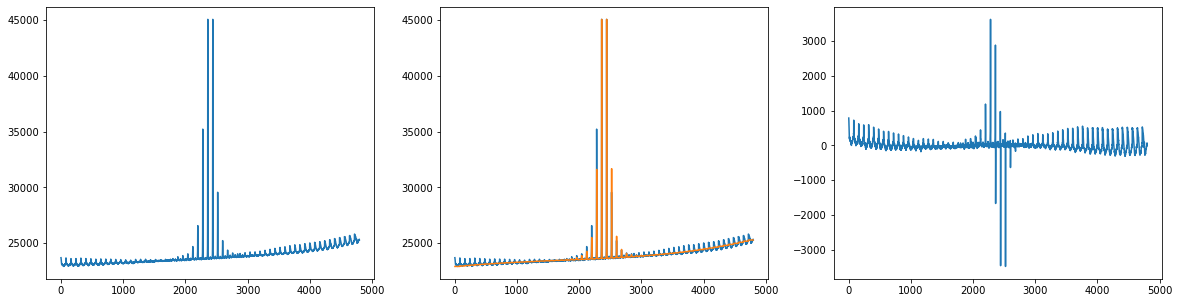

>> Date: 2017-12-08 09:48:45 Error: 135.07919019147133 C.A. Error: 898.8184931335209 Theta: [ 4.25760874e+01 -1.19962155e+00  1.96713072e-02  1.25997758e+06
  1.60998894e-01]


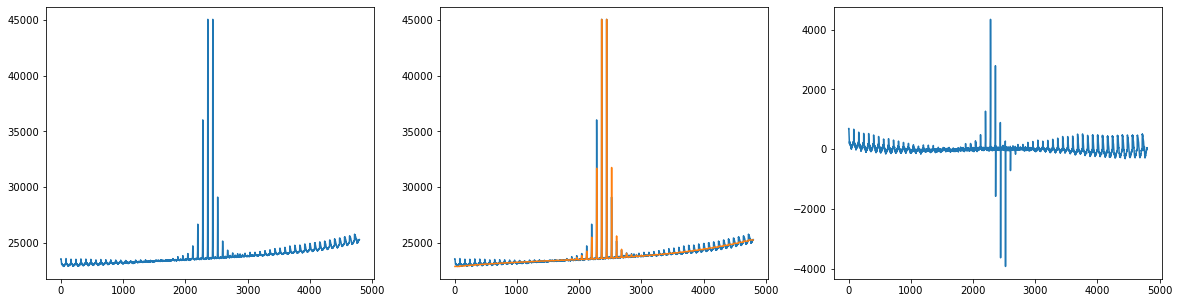

KeyboardInterrupt: 

In [36]:
# Direct radiation from the sun funcion
def _f_direct(w_2, w_3, XY_, x_):
    return w_2 * ( (w_3**2) / ( (XY_[:, 0] - x_[0])**2 + (XY_[:, 1] - x_[1])**2 + w_3**2 )**1.5 )[:, np.newaxis]

# Scatter radiation background function
def _f_scatter(w_0, w_1, w_2, XY_, x_):
    #return w_0 * np.exp( XY_[:, 1] * w_1)[:, np.newaxis]
    X_ = XY_[:, 1][:, np.newaxis]
    return w_2*X_**3 + w_1*X_**2 + w_0*X_

# Atmospheric Funtion
def _f(w_, beta, XY_, x_):
    # Unpck function parameters
    w_0, w_1, w_2, w_3, w_4 = w_
    # Evaluation of the scatter radiation function
    f_1 = _f_scatter(w_0, w_1, w_2, XY_, x_)
    # Evaluation of the direct radiation function
    f_2 = _f_direct(w_3, w_4, XY_, x_) 
    # Adding together both fuctions to obtained the atmospheric function
    Z_hat_ = f_1 + f_2 + beta
    Z_hat_[Z_hat_ > 45057.] = 45057
    return Z_hat_

# Atmospheric Function gradient
def _g(w_, XY_, x_):
    # Unpck function parameters
    w_0, w_1, w_2, w_3, w_4 = w_
    # Gradinet Constant
    _h = (XY_[:, 0] - x_[0])**2 + (XY_[:, 1] - x_[1])**2 + w_3**2 
    # Calculate each parameter gradiante
    g_0_ = np.exp( (XY_[:, 1] - x_[1])/w_1 )
    g_1_ = - w_0 * ( (XY_[:, 1] - x_[1])/w_1**2 ) * np.exp( (XY_[:, 1] - x_[1])/w_1 )
    g_2_ = w_3**2 / _h**1.5
    g_3_ = w_2 * w_3 * (2*(XY_[:, 0] - x_[0])**2 + 2*(XY_[:, 1] - x_[1])**2 - w_3**2) / _h**2.5 
    # And concatenate together to define the function gradient
    return np.concatenate((g_0_[:, np.newaxis], g_1_[:, np.newaxis], g_2_[:, np.newaxis], g_3_[:, np.newaxis]), axis = 1)

# RMSE
def _E(w_, x_, z_, XY_, D):
    beta = z_.min()
    return np.sqrt( np.mean(  (z_ - _f(w_, beta, XY_, x_))**2 ) )

# Derivatif of the RMSE
def _dE(w_, x_, z_, XY_, D):
    # Evaluation of the Atmoshperic function
    z_hat_  = _f(w_, XY_, x_)
    # Evaluation of the Atmospheric function gradient
    dZ_hat_ = _g(w_, XY_, x_)   
    # Definiton of the the error function gradient
    E_ = 2*dZ_hat_ - 2*z_*dZ_hat_
    return np.sum(E_, axis = 0)

# Implementation of the line search gradient based optimization method
def _optimize(_f, _g, bounds_, args_, n_init, approx_grad):
    # Random initialization of the line search for each kernel hyper-parameter within the bounds.
    def __rand_init(bounds_):
        n_var   = len(bounds_)
        x_init_ = np.zeros(n_var)
        for i in range(n_var):
            x_init_[i] = np.random.uniform(bounds_[i][0], bounds_[i][1])                             
        return x_init_
    # Variables Initialization
    f_ = []
    x_ = []
    i = 0
    # Loop over no. of initializations
    while i < n_init:  
        # Run the line search BFGS optimization!
        OPT_ = fmin_l_bfgs_b(_f, x0 = __rand_init(bounds_), fprime = _g, args = args_, 
                                     bounds = bounds_, maxfun = 15000, approx_grad = approx_grad)
        # Save only results that converge to optima
        if not np.isnan(OPT_[1]):
            f_.append(OPT_[1])
            x_.append(OPT_[0])
            i+=1
    # Get best result of all initializations
    i = np.argmin(f_)
    return f_[i], x_[i], i

# Calculate the model error in the circumsolar area
def _inner_circumsolar_area_error(z_, z_hat_, XYZ_, x_, r = 6):
    idx_ = np.sqrt((XYZ_[:, 0] - x_[0])**2 + (XYZ_[:, 1] - x_[1])**2) < r
    return np.sqrt(np.mean((z_[idx_] - z_hat_[idx_])**2))


# Calculate the model error in the circumsolar area
def _outter_circumsolar_area_error(z_, z_hat_, XYZ_, x_, r = 6):
    idx_ = np.sqrt((XYZ_[:, 0] - x_[0])**2 + (XYZ_[:, 1] - x_[1])**2) > r
    return np.sqrt(np.mean((z_[idx_] - z_hat_[idx_])**2))

def _error(z_, z_hat_):
    return np.sqrt(np.mean((z_ - z_hat_)**2))

# List of results Initialization
BD_ = [] 
BA_ = [] 
BW_ = [] 
BE_ = [] 
BC_ = [] 
BT_ = []
# loop over days
for i in range(len(X_)):
    # Variable Initialization
    DA_ = np.empty((0, 2))
    DW_ = np.empty((0, 4))
    DE_ = np.empty((0, 1))
    DC_ = np.empty((0, 1))
    DT_ = np.empty((0, 1), dtype = 'datetime64')
    day = str(X_[i][0, :][4]).split(' ')[0]
    print(day)
    # loop over samples in each day
    for ii in range(400, X_[i].shape[0]):
        # Extract Data and Define Dataset
        t_ = X_[i][ii, :][4]
        a_ = np.array([X_[i][ii, :][0], X_[i][ii, :][1]]).T
        x_ = np.hstack((X_[i][ii, :][2], X_[i][ii, :][3]))[:, np.newaxis]
        z_ = Y_[i][ii, :][:, np.newaxis]
        D  = z_.shape[0] * z_.shape[1]
        # Optimization Parameters Boundaries 
        bounds_ = [(-100., 100.), (-100., 100.),  (-100., 100.), (1e6, 1e7), (0., 1.)]
        OPT_ = _optimize(_E, _dE, bounds_, args_ = (x_, z_, XYZ_, D), n_init = 3, approx_grad = True)
        # Get Results of Model Approximation
        #e  = np.sqrt(OPT_[0])
        w_ = OPT_[1]
        #w_ = [10, 10, 1e6, 0.1]
        # Model prediction for test
        beta   = z_.min()
        z_hat_ = _f(w_, beta, XYZ_, x_)
        #print(z_.shape, z_hat_.shape)
        e = _outter_circumsolar_area_error(z_, z_hat_, XYZ_, x_)
        c = _inner_circumsolar_area_error(z_, z_hat_, XYZ_, x_)
        # Diplay sample results summary
        #w_ = np.concatenate((w_, k_), axis = 0)
        #print(g_.max())
        print('>> Date: {} Error: {} C.A. Error: {} Theta: {}'.format(t_, e, c, w_))
        # Display and get best models according to error and circumsolar area error
        #if e < 200. and c < 200.:
        plt.figure(figsize = (20, 5))
        plt.subplot(131)
        plt.plot(z_)
        plt.subplot(132)
        plt.plot(z_)
        plt.plot(z_hat_)
        plt.subplot(133)
        plt.plot(z_ - z_hat_)
        plt.show()

#         # Save Model that approximate the function best
#         DA_ = np.vstack((DA_, a_))
#         DW_ = np.vstack((DW_, w_))
#         DE_ = np.vstack((DE_, e))
#         DC_ = np.vstack((DC_, c))
#         DT_ = np.vstack((DT_, t_))
#     print(DA_.shape, DW_.shape, DE_.shape, DC_.shape, DT_.shape)
#     # Append all the data from all the days
#     BD_.append(day)
#     BA_.append(DA_)
#     BW_.append(DW_)
#     BE_.append(DE_)
#     BC_.append(DC_)
#     BT_.append(DT_)
#     print(len(BD_), len(BA_), len(BW_), len(BE_), len(BC_), len(BT_))
    
# save the Dataset
# path = r'C:\Users\Guille\Desktop\infrared_radiometry\atmospheric_model\{}'
# name = r'atmospheric_model_parameters_dataset.pkl'
# file = path.format(name)
# print(file)
# _save_data([BD_, BA_, BW_, BE_, BC_, BT_], file)